In [1]:
from prettyfigure.style import *

%matplotlib inline
from colossus.Cosmology import *
from colossus.HaloConcentration import *
from colossus.HaloDensityProfile import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betainc

import cosmolopy as cp

from dmb.single_halo import *
from dmb.mass_func import *

define_figure_style()
setCosmology('planck15')
cosmo = getCurrent()

params = {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.2, 'cosmo': cosmo}

dm_data = np.genfromtxt('PPPC4DM/AtProductionNoEW_positrons.dat', names=True)
def get_electron_spec(e=5):
    '''
    Returns the electron energy specrum 
    '''
    return 10**dm_data['Log10x'][dm_data['mDM']==e], dm_data['q'][dm_data['mDM']==e]

In [2]:
def CLfit(z, params):
    if params == {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.2, 'cosmo': cosmo}:
        return 1.0+6.3e5*z**-1.20*np.exp(-(z/45)**2.3)
    if params == {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.2, 'cosmo': cosmo}:
        return 1.0+3.2e5*z**-1.180*np.exp(-(z/40)**2.3)
    if params == {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo}:
        return 1.0+5.e4*z**-1.140*np.exp(-(z/34)**2.2)
    if params == {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0, 'cosmo': cosmo}:
        return 1.0+3.5e4*z**-1.06*np.exp(-(z/32)**2)


In [3]:
# Mass of dm particle in GeV
mx = 10
sigmav = 1e-26

# Mass of 1 GeV
g_in_GeV = 1.782e-24 

n_dm = AST_rho_crit_0_kpc3*cosmo.Om0/AST_kpc**3*AST_Msun*cosmo.h**2/mx/g_in_GeV
n_b = AST_rho_crit_0_kpc3*cosmo.Ob0/AST_kpc**3*AST_Msun*cosmo.h**2/1.672e-24
# 
print 'Number density of DM particles in a cm^3: ', n_dm
print '"Number density" of baryons in a cm^3:    ', n_b


Number density of DM particles in a cm^3:  1.49418490335e-07
"Number density" of baryons in a cm^3:     2.5054984114e-07


In [4]:
z_list = np.logspace(0, np.log10(3000), 100)[::-1]
age_list = cp.distance.age(z_list, **cp.fidcosmo)

rho_eff = (1.0+z_list)**3 * np.sqrt(CLfit(z_list, params))*n_dm*mx
# plt.plot(z_list[:], rho_eff)
# plt.plot(z_list[:], (1+z_list)**3*n_dm*mx)
# plt.xscale('log')
# plt.yscale('log')

In [5]:
An_rate = rho_eff**2/mx**2/2*sigmav

Re_rate = (1.0+z_list)**6*n_b**2*3e-13

ion_per_ann = mx*1e9*0.3/13.6

# plt.plot(z_list, (Re_rate/(An_rate*ion_per_ann))**-0.5)
# # plt.plot(z_list, Re_rate)
# plt.xscale('log')
# plt.yscale('log')

In [6]:
adata = np.loadtxt('N20/A.txt', comments='#')
# bdata = np.loadtxt('N20/B.txt', comments='#')

z_list_model = np.linspace(0, 200, 10000)
x_HII_list = np.interp(z_list_model, 1./adata[::-1,0]-1.0, adata[::-1,9])
x_HeII_list = np.interp(z_list_model, 1./adata[::-1,0]-1.0, adata[::-1,11], left = 0)
x_HeIII_list = np.interp(z_list_model, 1./adata[::-1,0]-1.0, adata[::-1,12], left = 0)

x_HeIII_list[:249] = np.interp(z_list_model[:249],[0.0, 3.0, 5.0],[0.97,0.97,0.14])
x_HeII_list[:249] = 0.97-x_HeIII_list[:249]

# plt.plot(z_list_model, x_HII_list,'-',lw=1)
# plt.plot(z_list_model, x_HeII_list,'--')
# plt.plot(z_list_model, x_HeIII_list,'-.')
# # plt.xscale('log')
# # plt.yscale('log')
# plt.ylim([1e-4,1])
# plt.xlim([0,15])

# print cp.cr.integrate_optical_depth(np.array([1.0, 1.0]), 2.0*np.array([1.0, 1.0]), np.array([0.0, 5.0]), **cp.fidcosmo)[-1]

print cp.cr.integrate_optical_depth(x_HII_list, x_HeII_list+2.0*x_HeIII_list, z_list_model, **cp.fidcosmo)[-1]

0.058817941465


In [7]:
import radiator
from radiator.crosssections import *
cs = cross_sections(cs={'photion': 'VFKY1996', 'collion': 'AR', 'collex': 'SKD'})

In [8]:
# cosmo = Cosmology.setCosmology('planck13')
sigmaT = 6.6524e-25 #cm^2
me = 9.109e-28 # g
c = 2.9979e10 # cm/s
hbar = 1.0545e-27 # erg*s
kB = 1.380648e-16 # erg/K

Eg_list = np.logspace(-6, 12, 1000)/6.24e11
nu_list = Eg_list / (hbar*2*np.pi)
EgeV_list = Eg_list*6.24e11
z_start = 200.0
z_step = 0.01
z_list = np.array([0])

f = (Eg_list[1]/Eg_list[0])**1
double_shift = int(np.ceil(np.log(2.0)/np.log(f)))
for i in range(1000):
    z_list = np.append(z_list, f*(1.+z_list[-1])-1.0)
z_list = z_list[z_list <= z_start]
z_list = z_list[::-1]
boost = CLfit(z_list, params)

import cosmolopy as cp
age_list = cp.distance.age(z_list,**cp.fidcosmo)

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


In [9]:
z = z_list[0]
T_CMB = 2.7*(1+z)
CMBphotons = 8*np.pi*2*np.pi*hbar*nu_list**3/c**3/(np.exp(2.0*np.pi*hbar*nu_list/kB/T_CMB)-1.0)/Eg_list/(hbar*2*np.pi)
print 'number of photons per cm^3: ', np.trapz(CMBphotons, Eg_list)

number of photons per cm^3:  2926804685.83


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


In [10]:
x, y = get_electron_spec(e=mx)
# plt.plot(x, y)
# plt.yscale('log')
# plt.xscale('log')
print np.trapz(y*x*mx, np.log10(x))/mx
print np.sum(y*x*mx*np.gradient(np.log10(x)))/mx

e_add = np.interp(EgeV_list, x*mx*1e9, y*np.gradient(np.log10(x))/np.gradient(x), left=0, right=0)
# e_add *= np.gradient(EgeV_list)

e_add = e_add*np.gradient(EgeV_list)/1e9/mx

np.sum(e_add*EgeV_list)/1e9/mx

0.156327652959
0.156331377959


0.1570657874561994

In [11]:
n_ion = np.zeros([len(z_list), 10])
electronsN = np.zeros(len(EgeV_list))
photons_particles = np.zeros(len(Eg_list))

Sigma_photoion = cs.sigmaX(EgeV_list, 1, 1)
Sigma_photoion_HeI = cs.sigmaX(EgeV_list, 2, 2)
Sigma_photoion_HeII = cs.sigmaX(EgeV_list, 2, 1)

def ICon30CMB(EgeV_list, E0, z):
    return (1+z)**-0.5 * 3.8e-1 * (EgeV_list/1e9)**0.5 * \
           np.exp(\
               -(EgeV_list/1e9)*2.4e3* \
               (1.3e9/E0)**2. / \
               ((1.+z)/61)**1. \
               )


d_x_HII_d_z=np.interp(z, z_list_model, np.gradient(x_HII_list)/np.gradient(z_list_model))

predicted_rhist = np.ones([len(z_list),10])*1e-8 # xHII, xHeII, xHeIII
predicted_rhist[0, 0] = 2e-4

age_list = cp.distance.age(z_list, **cp.fidcosmo)

for ii in range(len(z_list)-1):
    print ii
    # time step
    dt = age_list[ii+1]-age_list[ii]
    tau = dt
    print 'Time step [yrs]:', tau/3.14e7
    # current redshift
    z = 0.5 * (z_list[ii+1] + z_list[ii])
#     print 'z=%5.1f'%z
    # CMB temperature
    T_CMB = 2.7*(1+z)
    # update CMB
    CMBphotons = 8*np.pi*2*np.pi*hbar*nu_list**3/c**3/(np.exp(2.0*np.pi*hbar*nu_list/kB/T_CMB)-1.0)/Eg_list/(hbar*2*np.pi)
#     print 'number of photons per cm^3: ', np.trapz(CMBphotons, Eg_list)
    # add sources
#     photons_particles += (phot2/(EgeV_list/1e9)**2*np.gradient(EgeV_list/1e9))*boost[ii]*(1.0+z)**3*tau
    electronsN += boost[ii]*(1.0+z)**6 * n_dm**2 * sigmav * tau * e_add
#     print EgeV_list[800]
    photons_particles[:-1] = photons_particles[1:]
    photons_particles[:-1] = 0
    # add IC photons
    for i in range(len(electronsN)):
        photons_particles += electronsN[i] * ICon30CMB(EgeV_list, EgeV_list[i], z) * np.gradient(Eg_list) / Eg_list**2
    print np.sum(EgeV_list*photons_particles), np.sum(EgeV_list*electronsN)
    electronsN *= 0
    # column density
    N_naked = n_b*c*tau*(1+z)**3
    N_H = N_naked*0.76*(1.0-predicted_rhist[ii, 0])
    N_HeI = N_naked*0.24/4*(1.0-predicted_rhist[ii, 1]-predicted_rhist[ii, 2])
    N_HeII = N_naked*0.24/4*(predicted_rhist[ii, 1])
    n_HI = (1.0 - predicted_rhist[ii, 0]) * 0.76 * n_b
    n_HII = predicted_rhist[ii, 0] * 0.76 * n_b
    n_HeI = (1.0-predicted_rhist[ii, 1]-predicted_rhist[ii, 2]) * 0.24/4 * n_b
    n_HeII = (predicted_rhist[ii, 1]) * 0.24/4 * n_b
    n_HeIII = (predicted_rhist[ii, 2]) * 0.24/4 * n_b
    n_e = 0.0 + n_HII+n_HeII+n_HeIII*2
    n_ion[ii,9] = (1.0+z)**3 * n_e * 4.2e-13 * tau
#     N_O = N_naked*0.01/8
    # photoion
    temp_factor_H = (Sigma_photoion*N_H)
    temp_factor_He = (Sigma_photoion_HeI*N_HeI)
    temp_factor_HeII = (Sigma_photoion_HeII*N_HeII)
    temp_factor_H[EgeV_list < 13.6] = 0.0
    temp_factor_He[EgeV_list < 24.6] = 0.0
    temp_factor_HeII[EgeV_list < 40.2] = 0.0
    # temp_factor_O[EgeV_list < 13.6] = 0.0
    temp_factor = temp_factor_H + temp_factor_He + temp_factor_HeII # + temp_factor_O
    temp_factor_H[temp_factor > 1.0] /= temp_factor[temp_factor > 1.0]
    temp_factor_He[temp_factor > 1.0] /= temp_factor[temp_factor > 1.0]
    temp_factor_HeII[temp_factor > 1.0] /= temp_factor[temp_factor > 1.0]
    # temp_factor_O[temp_factor > 1.0] /= temp_factor[temp_factor > 1.0]
    temp_factor[temp_factor > 1.0] = 1.0
    temp = photons_particles * temp_factor
    print temp_factor_H.sum(), temp_factor_He.sum(), temp_factor_HeII.sum()
    d_x_HII = np.interp(z, z_list_model, np.gradient(x_HII_list)/np.gradient(z_list_model))*(z_list[ii]-z_list[ii+1])
    temp_H = photons_particles * temp_factor_H * (EgeV_list-13.6)
    temp_H[EgeV_list<13.6*2.5] = 0
    temp_He = photons_particles * temp_factor_He * (EgeV_list-24.4)
    temp_He[EgeV_list<24.4+13.6*2] = 0
    temp_HeII = photons_particles * temp_factor_HeII * (EgeV_list-40.2)
    temp_HeII[EgeV_list<40.2+13.6*2] = 0
    energy_in_electrons = np.sum(temp_H) + np.sum(temp_He) + np.sum(temp_HeII)
#     print np.sum(temp_factor_H)
    n_ion[ii, 0] += np.sum(photons_particles * temp_factor_H) 
    n_ion[ii, 0] += (1-predicted_rhist[ii, 0])/3.0 * energy_in_electrons / 13.6
    n_ion[ii, 4] += np.sum(photons_particles * temp_factor_He)
    n_ion[ii, 8] += np.sum(photons_particles * temp_factor_HeII)
    # n_ion[ii, 8] += np.sum(photons_particles * temp_factor_O)
    photons_particles -= temp
#     n_ion[ii,8] = 0.93*3.14e7*1e9*((1.+z)/7.)**-3
#     print tau/3.14e7, n_ion[ii,8]/3.14e7
#     predicted_rhist[ii+1, 0] = np.max([predicted_rhist[ii, 0], np.sum(n_ion[:ii+1,0])])
    predicted_rhist[ii+1, 0] = predicted_rhist[ii, 0] - \
                               (1+z)**3 * n_e * predicted_rhist[ii, 0] * 4.2e-13 * dt + \
                               n_ion[ii,0] / (1+z)**3 / n_HI
    predicted_rhist[ii+1, 0] = np.max([predicted_rhist[ii+1, 0], np.interp(z_list[ii+1], z_list_model, x_HII_list)])
    predicted_rhist[ii+1, 0] = np.min([predicted_rhist[ii+1, 0], 1.0])
    predicted_rhist[ii+1, 1] = predicted_rhist[ii, 1] - \
                               (1+z)**3 * n_e * predicted_rhist[ii, 1] * 6 * 4.2e-13 * dt + \
                               n_ion[ii,4] / (1+z)**3 / n_HeI
    predicted_rhist[ii+1, 1] = np.max([predicted_rhist[ii+1, 1], np.interp(z_list[ii+1], z_list_model, x_HeII_list)])
    predicted_rhist[ii+1, 1] = np.min([predicted_rhist[ii+1, 1], 1.0])
    predicted_rhist[ii+1, 2] = predicted_rhist[ii, 2] - \
                               (1+z)**3 * n_e * predicted_rhist[ii, 2] * 6 * 4.2e-13 * dt + \
                               n_ion[ii,8] / (1+z)**3 / n_HeII
    predicted_rhist[ii+1, 2] = np.max([predicted_rhist[ii+1, 2], np.interp(z_list[ii+1], z_list_model, x_HeIII_list)])
    predicted_rhist[ii+1, 2] = np.min([predicted_rhist[ii+1, 2], 1.0])
    print z, np.sum(photons_particles * temp_factor_H)*13.6/(boost[ii]*(1.0+z)**6 * n_dm**2 * sigmav * mx*1e9 / 4.0 * tau)

0
Time step [yrs]: 422823.842916
0.000186709995426 0.000220910157885
139.952304104 279.677424116 2.51274232633e-06
189.271049671 1.19071887658e-16
1
Time step [yrs]: 449973.030668
0.000154912491265 0.000183288238079
139.832087348 279.370925411 0.000193482418038
181.538591892 1.04049391866e-16
2
Time step [yrs]: 478865.444868
0.000128530244093 0.00015207349665
139.709609429 279.058608157 0.000374126606375
174.120374789 9.14400311129e-17
3
Time step [yrs]: 509613.016278
0.000106641059992 0.000126174820327
139.592800412 278.760732294 0.000545088489391
167.003627881 7.7579400797e-17
4
Time step [yrs]: 542334.862555
8.84800152755e-05 0.000104687173385
139.467788486 278.44186574 0.000706870689388
160.17609967 6.91734597599e-17
5
Time step [yrs]: 577157.749687
7.34134088254e-05 8.68607788194e-05
139.350320704 278.142236098 0.000860108490086
153.626036548 5.83857293666e-17
6
Time step [yrs]: 614216.583064
6.09189410062e-05 7.20776666336e-05
139.226851065 277.827243224 0.00100520388959
147.3421

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:92: RuntimeWarning: invalid value encountered in double_scalars


 1.14156503719e-06
0.0 -9.7197108516e+21 1.12664065835e+21
3.18518881903 0.0
93
Time step [yrs]: 135171312.241
8.52875474749e-07 1.00912532705e-06
nan -1.13225693331e+22 1.67783233874e+21
3.01510621373 nan
94
Time step [yrs]: 143473934.289
nan 8.92547461698e-07
nan nan nan
2.85193562456 nan
95
Time step [yrs]: 152236139.012
nan 7.89900735937e-07
nan nan nan
2.69539615291 nan
96
Time step [yrs]: 161473649.617
nan 6.99492075858e-07
nan nan nan
2.54521831567 nan
97
Time step [yrs]: 171200806.435
nan 6.19836817641e-07
nan nan nan
2.40114358128 nan
98
Time step [yrs]: 181430127.178
nan 5.4963306831e-07
nan nan nan
2.26292392469 nan
99
Time step [yrs]: 192171808.673
nan 4.87739218156e-07
nan nan nan
2.13032140041 nan
100
Time step [yrs]: 203433170.985
nan 4.33154224751e-07
nan nan nan
2.00310773282 nan
101
Time step [yrs]: 215218048.058
nan 3.85000333405e-07
nan nan nan
1.88106392326 nan
102
Time step [yrs]: 227526133.058
nan 3.42507939018e-07
nan nan nan
1.76397987299 nan
103
Time step [yrs

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:67: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:68: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:71: RuntimeWarning: invalid value encountered in greater


0.0144725759232


(1, 150)

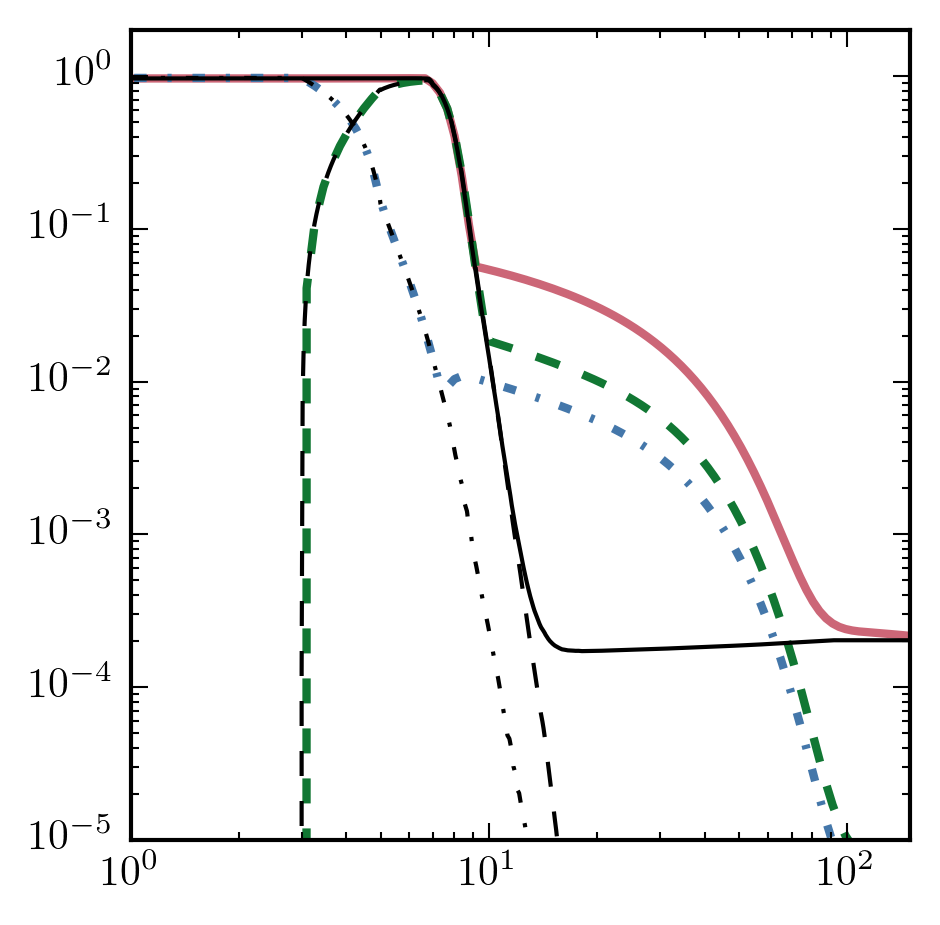

In [14]:
predicted_rhist[z_list<5,0] = np.interp(z_list, z_list_model, x_HII_list)[z_list<5]
predicted_rhist[z_list<5,1] = np.interp(z_list, z_list_model, x_HeII_list)[z_list<5]
predicted_rhist[z_list<5,2] = np.interp(z_list, z_list_model, x_HeIII_list)[z_list<5]
predicted_rhist[:,3] = np.interp(z_list, z_list_model, x_HII_list)
predicted_rhist[:,4] = np.interp(z_list, z_list_model, x_HeII_list)
predicted_rhist[:,5] = np.interp(z_list, z_list_model, x_HeIII_list)

plt.plot(z_list, predicted_rhist[:,0])
plt.plot(z_list, predicted_rhist[:,1],'--')
plt.plot(z_list, predicted_rhist[:,2],'-.')

tau_original = cp.cr.integrate_optical_depth(predicted_rhist[:,3], predicted_rhist[:,4]+2.0*predicted_rhist[:,5], z_list, **cp.fidcosmo)[-1]
tau_mod = cp.cr.integrate_optical_depth(predicted_rhist[:,0], predicted_rhist[:,1]+2.0*predicted_rhist[:,2], z_list, **cp.fidcosmo)[-1]
print tau_mod-tau_original

# print predicted_rhist
plt.plot(z_list_model, x_HII_list,'-k',lw=1)
plt.plot(z_list_model, x_HeII_list,'--k',lw=1)
plt.plot(z_list_model, x_HeIII_list,'-.k',lw=1)

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-5, 2e0])
# plt.ylim([1e-4,1e-3])
plt.xlim([1,150])


C:\Anaconda\lib\site-packages\matplotlib\scale.py:100: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


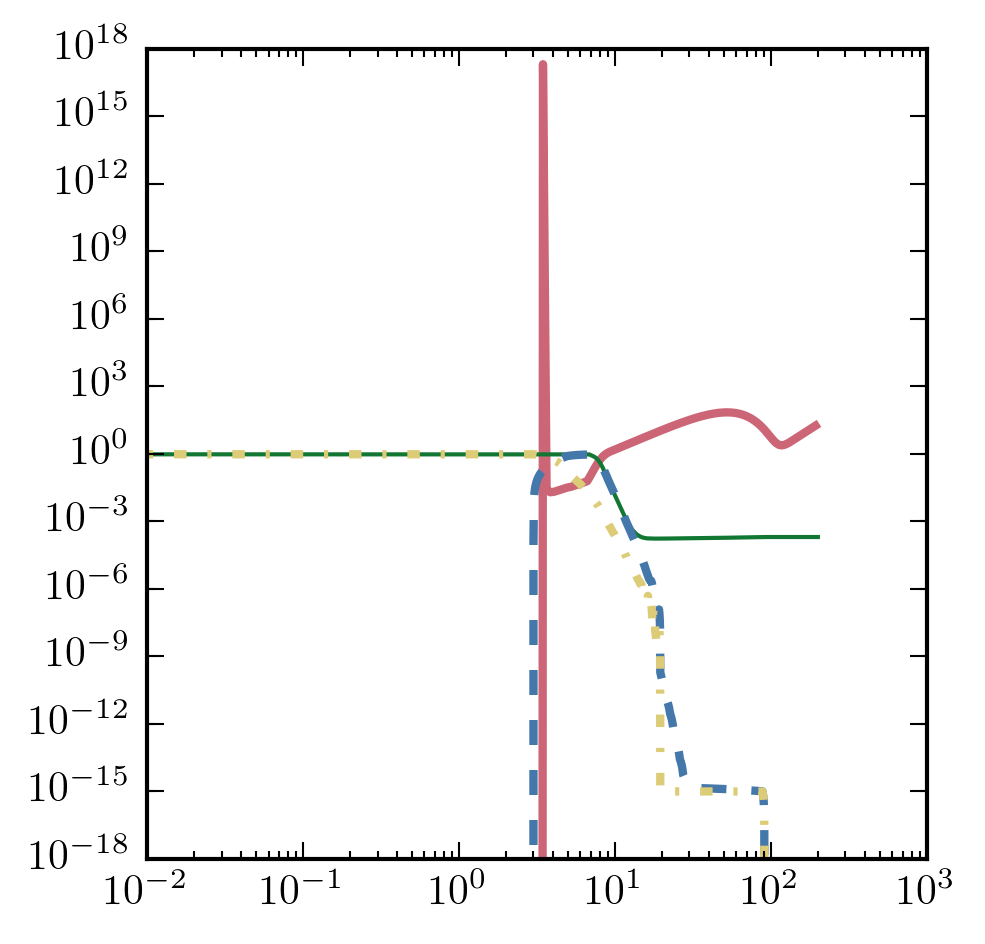

In [13]:
plt.plot(z_list, n_ion[:,0]/n_b)
# plt.plot(z_list, n_ion[:,9]/n_b*1e-8/(1.0+z_list)**3)

plt.plot(z_list_model, x_HII_list,'-',lw=1)
plt.plot(z_list_model, x_HeII_list,'--')
plt.plot(z_list_model, x_HeIII_list,'-.')

plt.xscale('log')
plt.yscale('log')

In [ ]:
z=95
tau = cp.distance.age(90, **cp.fidcosmo) - cp.distance.age(100, **cp.fidcosmo)
xi=2e-4
print (1.0+z)**3 * n_b * xi * 4.2e-13 * tau

In [ ]:
np.cumsum(n_ion[:ii+1,0])

In [ ]:
n_ion[:,8]/n_ion[:,4]

In [ ]:
temp=z_list.copy()*0
for ii in range(len(z_list)-1):
    print ii
    # time step
    dt = age_list[ii+1]-age_list[ii]
    tau = dt
    print 'Time step [yrs]:', tau/3.14e7, temp[ii]
    # current redshift
    z = 0.5 * (z_list[ii+1] + z_list[ii])
    temp[ii+1] = temp[ii] + \
                 (boost[ii] * (1.0+z)**6 * n_dm**2 * sigmav * mx*1e9 * tau / 13.6)/n_b/(1+z)**3

In [ ]:
plt.plot(z_list, temp)
plt.yscale('log')
plt.xscale('log')
# plt.ylim([1e-5, 2e0])
# plt.ylim([1e-4,1e-3])
plt.xlim([1,300])